# inter-run comparisons of N contained in phytoplankton
    - S3
    - Sentry Shoal
    - Central Node
    - JDF

In [1]:
import pandas as pd
import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
import cmocean
import numpy as np
import os
import re
import dateutil as dutil
from salishsea_tools import viz_tools, places, evaltools as et
import glob
import pickle
import matplotlib.dates as mdates
import matplotlib as mpl
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=16) 
mpl.rc('legend', fontsize=16) 
mpl.rc('axes', titlesize=16) 
mpl.rc('figure', titlesize=16) 
mpl.rc('axes', labelsize=16) 
mpl.rc('font', size=16) 

mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.numpoints'] = 1
%matplotlib inline

### definitions

In [2]:
ChlToN=1.8
rundict={'202007Gp2':'/home/sallen/202007/202007G-p2',
         '202007Jp2':'/home/sallen/202007/202007J-p2',
         '202007K':'/home/sallen/202007/202007K',
         '201812':'/results/SalishSea/nowcast-green.201812/',
         '201905':'/results2/SalishSea/nowcast-green.201905/'}
namfmt={'202007Gp2':'long',
        '202007Jp2':'long',
        '202007K':'long',
        '201812':'nowcast',
        '201905':'nowcast'}
tres={'202007Gp2':24,
      '202007Jp2':24,
      '202007K':24,
      '201812':1,
      '201905':24}
cols={'202007Gp2':'y',
      '202007Jp2':'orange',
      '202007K':'k',
      '201812':'b',
      '201905':'m'}
startdate=dt.datetime(2017,3,1)
enddate=dt.datetime(2017,4,30)
yearstr='2017'
len(rundict)

5

### load ferry data

In [3]:
flist=['search4979680/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170217T003041Z_20170315T031911Z-clean.csv',
       'search4979680/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170315T031912Z_20170404T195130Z-clean.csv',
       'search4979680/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170404T195131Z_20170426T173215Z-clean.csv',
       'search4979680/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170426T173216Z_20170522T011843Z-clean.csv',
       'search4979680/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170522T011844Z_20170611T234016Z-clean.csv',
       'search4979680/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170611T234017Z_20170702T172228Z-clean.csv',
       'search4979680/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170702T172229Z_20170722T182606Z-clean.csv',
       'search4979680/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170722T182607Z_20170815T213737Z-clean.csv',
       'search4979680/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170815T213738Z_20170825T225506Z-clean.csv',
       'search7672208/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170825T225507Z_20170923T032427Z-clean.csv',
       'search7672208/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170923T032428Z_20171016T213134Z-clean.csv',
       'search7672208/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20171016T213135Z_20180108T160335Z-clean.csv',]
dfs=list()
for ii in range(0,len(flist)):
    dfs.append(pd.read_csv('/ocean/eolson/MEOPAR/obs/ONC/turbidity/nearSurface/'+flist[ii],
        skiprows=67,header=None,
        usecols=['TimeUTC','Chlorophyll_ug','ChlQC','Lat','LatQC','Lon','LongQC'],
        names=('TimeUTC','CDOM','CDOMQC','Chlorophyll_ug','ChlQC','Turbidity_NTU','TurbQC','Lat','LatQC','Lon','LongQC',
               "Pitch", "PitchQC","Roll","RollQC","TrueHeading", "TrueHeadingQC"),
        dtype={'TimeUTC':str,'Chlorophyll_ug':str,'ChlQC':int,'Lat':str,'LatQC':int,
                      'Lon':str,'LongQC':int}))

df=pd.concat(dfs,ignore_index=True)
df.drop(df[df.TimeUTC<yearstr].index,inplace=True)
dts=[dt.datetime(int(r[0:4]),int(r[5:7]),int(r[8:10]),int(r[11:13]),int(r[14:16]),int(r[17:19])) for r in df['TimeUTC']]
df=df.assign(dts=dts)
df['Lat']=pd.to_numeric(df['Lat'],errors='coerce')
df['Lon']=pd.to_numeric(df['Lon'],errors='coerce')
df['Chlorophyll_ug']=pd.to_numeric(df['Chlorophyll_ug'],errors='coerce')
df.dropna(subset=['TimeUTC','Chlorophyll_ug','Lat','Lon'],inplace=True)
df.head()

,TimeUTC,Chlorophyll_ug,ChlQC,Lat,LatQC,Lon,LongQC,dts
0,2017-02-17T00:30:42.369Z,2.0178,1,49.177814,8,-123.641612,8,2017-02-17 00:30:42
1,2017-02-17T00:30:43.444Z,1.9352,1,49.177854,8,-123.641739,8,2017-02-17 00:30:43
2,2017-02-17T00:30:44.518Z,1.9352,1,49.177895,8,-123.641867,8,2017-02-17 00:30:44
3,2017-02-17T00:30:45.593Z,1.9116,1,49.177935,8,-123.641994,8,2017-02-17 00:30:45
4,2017-02-17T00:30:46.667Z,1.9352,1,49.177975,8,-123.642122,8,2017-02-17 00:30:46


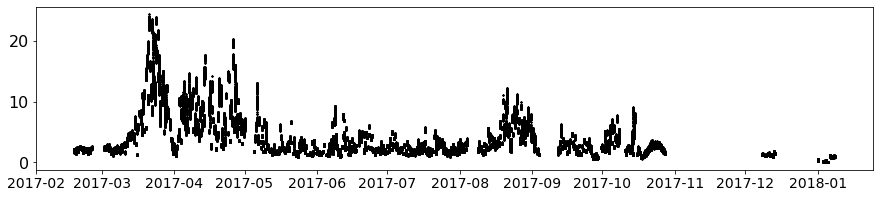

In [4]:
ij,ii=places.PLACES['S3']['NEMO grid ji']
llon=places.PLACES['S3']['lon lat'][0]-.01
ulon=places.PLACES['S3']['lon lat'][0]+.01
llat=places.PLACES['S3']['lon lat'][1]-.01
ulat=places.PLACES['S3']['lon lat'][1]+.01
iidfnd=(df.Lon>llon)&(df.Lon<ulon)&(df.Lat>llat)&(df.Lat<ulat)
fig,ax=plt.subplots(1,1,figsize=(15,3))
ax.plot(df.loc[iidfnd,['dts']],df.loc[iidfnd,['Chlorophyll_ug']],'k*',ms=2)

In [5]:
df.drop(df[(df.dts<startdate)|(df.dts>enddate)].index,inplace=True)

In [6]:
fname='/data/eolson/results/MEOPAR/SS36runs/calcFiles/bloomTime/bloom2017.pkl'
if os.path.isfile(fname):
    with open(fname, 'rb') as ff:
        data=pickle.load(ff)
        diat=data['diat']
        myri=data['myri']
        nano=data['nano']
        tt=data['tt']
else:
    diat=dict()
    myri=dict()
    nano=dict()
    tt=dict()
    for key in rundict:
        print(key,dt.datetime.now())
        fin=et.index_model_files(startdate,enddate,rundict[key],namfmt[key],1,'ptrc_T',tres[key])
        fobj=xr.open_mfdataset(fin['paths'])
        tt[key]=fobj.time_centered if 'time_centered' in fobj.coords else fobj.time_counter
        diat[key]=fobj.diatoms.isel(deptht=slice(0,3),y=ij,x=ii).mean(dim='deptht').compute()
        myri[key]=fobj.ciliates.isel(deptht=slice(0,3),y=ij,x=ii).mean(dim='deptht').compute()
        nano[key]=fobj.flagellates.isel(deptht=slice(0,3),y=ij,x=ii).mean(dim='deptht').compute()
        fobj.close()
    data={'tt':tt,'diat':diat,'myri':myri,'nano':nano}
    with open(fname, 'wb') as ff:
        pickle.dump(data, ff)

In [7]:
meszdict1812={
    'zz_rate_mesozoo_winterconc': 0.41, 
    'zz_rate_mesozoo_summerconc': 1.0 ,
    'zz_rate_mesozoo_sumpeakval': np.expand_dims(np.array((0.53,   0.57,     0.35)) ,0),
    'zz_rate_mesozoo_sumpeakpos': np.expand_dims(np.array((135.000, 208.000, 296.000)),0),
    'zz_rate_mesozoo_sumpeakwid': np.expand_dims(np.array((40.0,   65.00,  44.00)),0)
}
meszdict1905={
    'zz_rate_mesozoo_winterconc': 0.38, 
    'zz_rate_mesozoo_summerconc': 1.0 ,
    'zz_rate_mesozoo_sumpeakval': np.expand_dims(np.array((0.55,   .55,     0.36)) ,0),
    'zz_rate_mesozoo_sumpeakpos': np.expand_dims(np.array((130.00,  206.00, 290.0)),0),
    'zz_rate_mesozoo_sumpeakwid': np.expand_dims(np.array((40.0,   70.00,  43.00)),0)
}
meszdictsusanA={
    'zz_rate_mesozoo_winterconc': 0.41, 
    'zz_rate_mesozoo_summerconc': 1.0 ,
    'zz_rate_mesozoo_sumpeakval': np.expand_dims(np.array((0.50,   .57,     0.35)) ,0),
    'zz_rate_mesozoo_sumpeakpos': np.expand_dims(np.array((140.00,  208.00, 296.0)),0),
    'zz_rate_mesozoo_sumpeakwid': np.expand_dims(np.array((40.0,   65.00,  44.00)),0)
}
meszdictsusanB={
    'zz_rate_mesozoo_winterconc': 0.41, 
    'zz_rate_mesozoo_summerconc': 1.0 ,
    'zz_rate_mesozoo_sumpeakval': np.expand_dims(np.array((0.50,   .57,     0.35)) ,0),
    'zz_rate_mesozoo_sumpeakpos': np.expand_dims(np.array((140.00,  208.00, 296.0)),0),
    'zz_rate_mesozoo_sumpeakwid': np.expand_dims(np.array((35.0,   65.00,  44.00)),0)
}

def calcMESZ(meszdict):
    zz_rate_mesozoo_winterconc = meszdict['zz_rate_mesozoo_winterconc']
    zz_rate_mesozoo_summerconc = meszdict['zz_rate_mesozoo_summerconc']
    zz_rate_mesozoo_sumpeakval = meszdict['zz_rate_mesozoo_sumpeakval']
    zz_rate_mesozoo_sumpeakpos = meszdict['zz_rate_mesozoo_sumpeakpos']
    zz_rate_mesozoo_sumpeakwid = meszdict['zz_rate_mesozoo_sumpeakwid']
    zz_day=np.arange(1,366) # in model, nday_year starts at 1 on jan 1
    dts=[dt.datetime(int(yearstr)-1,12,31)+dt.timedelta(days=float(ii)) for ii in zz_day]
    zz_day=np.expand_dims(zz_day,1)
    zz_MesZoBar = zz_rate_mesozoo_winterconc + \
        zz_rate_mesozoo_summerconc*(np.sum ( zz_rate_mesozoo_sumpeakval * \
                                np.exp(-(zz_day-zz_rate_mesozoo_sumpeakpos)**2/zz_rate_mesozoo_sumpeakwid**2),1) \
                    + np.sum ( zz_rate_mesozoo_sumpeakval * \
                                np.exp( -(zz_day-zz_rate_mesozoo_sumpeakpos-365.25)**2/zz_rate_mesozoo_sumpeakwid**2),1) \
                    + np.sum ( zz_rate_mesozoo_sumpeakval * \
                                np.exp( -(zz_day-zz_rate_mesozoo_sumpeakpos+365.25)**2/zz_rate_mesozoo_sumpeakwid**2),1) )
    return(dts,15*zz_MesZoBar)

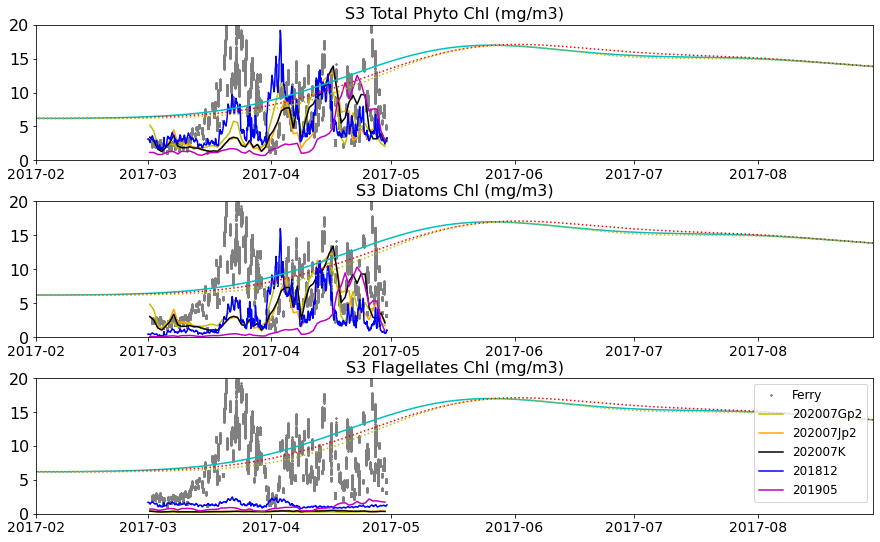

In [10]:
ChlToN=1.8
fig,ax=plt.subplots(3,1,figsize=(15,3*3))
fig.subplots_adjust(hspace=.3)
for iax in ax:
    iax.plot(df.loc[iidfnd,['dts']],df.loc[iidfnd,['Chlorophyll_ug']],'*',ms=2,color='gray',label='Ferry')
    iax.set_xlim(startdate,enddate)
for key in rundict:
    ax[0].plot(tt[key],ChlToN*(diat[key]+myri[key]+nano[key]),'-',color=cols[key],label=key)
    ax[1].plot(tt[key],ChlToN*(diat[key]),'-',color=cols[key],label=key)
    ax[2].plot(tt[key],ChlToN*(nano[key]),'-',color=cols[key],label=key)
    ax[0].set_title('S3 Total Phyto Chl (mg/m3)')
    ax[1].set_title('S3 Diatoms Chl (mg/m3)')
    ax[2].set_title('S3 Flagellates Chl (mg/m3)')
ax[2].legend(fontsize=12)
for iax in ax:
    iax.plot(*calcMESZ(meszdict1812),'c-')
    #iax.plot(*calcMESZ(meszdict1905),'g-')
    iax.plot(*calcMESZ(meszdictsusanA),'r:')
    iax.plot(*calcMESZ(meszdictsusanB),'y:')
    #iax.plot(*calcMESZ(meszdictT),'k:')
    iax.set_xlim(dt.datetime(int(yearstr),2,1),dt.datetime(int(yearstr),8,30))
    iax.set_ylim(0,20)